In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [56]:
df = pd.read_csv("datasets/target_molecules_clean_2.csv")
df.head()

,canonical_smiles,pIC50,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_2038,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047
0,O=C(O)/C=C/c1ccc(OS(=O)(=O)O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CN(CCCNC(=O)c1ccc(O)cc1)CCCNC(=O)c1ccc(O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CCN(CCCN(CC)C(=O)c1ccc(O)cc1)C(=O)c1ccc(O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CN(CCCNC(=O)c1ccc(O)cc1)CCCNC(=O)c1ccc2cc(O)cc...,3.531653,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CCN(CCOC(=O)/C=C/c1ccc(O)cc1)Cc1cc(Cl)ccc1O,4.337242,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df.dtypes

canonical_smiles     object
pIC50               float64
ECFP4_0               int64
ECFP4_1               int64
ECFP4_2               int64
                     ...   
ECFP4_2043            int64
ECFP4_2044            int64
ECFP4_2045            int64
ECFP4_2046            int64
ECFP4_2047            int64
Length: 2050, dtype: object

In [58]:
# Create a binary target column based on the condition pIC50 > 0.5
df['target'] = (df['pIC50'] > 5.0).astype(int)
df.head()

,canonical_smiles,pIC50,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047,target
0,O=C(O)/C=C/c1ccc(OS(=O)(=O)O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CN(CCCNC(=O)c1ccc(O)cc1)CCCNC(=O)c1ccc(O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CCN(CCCN(CC)C(=O)c1ccc(O)cc1)C(=O)c1ccc(O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CN(CCCNC(=O)c1ccc(O)cc1)CCCNC(=O)c1ccc2cc(O)cc...,3.531653,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CCN(CCOC(=O)/C=C/c1ccc(O)cc1)Cc1cc(Cl)ccc1O,4.337242,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:

import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [69]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch_geometric.data import Data
from tqdm import tqdm

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D coordinates

    # Node features
    node_feats = []
    for atom in mol.GetAtoms():
        atom_type = atom.GetAtomicNum()  # Atomic number as atom type
        charge = atom.GetFormalCharge()  # Formal charge
        hybridization = atom.GetHybridization()  # Hybridization
        valence = atom.GetTotalValence()  # Total valence
        degree = atom.GetDegree()  # Degree
        num_hydrogens = atom.GetTotalNumHs(includeNeighbors=True)  # Number of hydrogens
        chirality = atom.GetChiralTag()  # Chirality
        atomic_mass = atom.GetMass()  # Atomic mass
        aromatic = int(atom.GetIsAromatic())  # Aromatic (0 or 1)
        in_ring = int(atom.IsInRing())  # In ring (0 or 1)

        # Additional features can be included here, such as atom coordinates
        # atom_coords = mol.GetConformer().GetAtomPosition(atom.GetIdx())

        node_feats.append([atom_type, charge, hybridization, valence, degree,
                           num_hydrogens, chirality, atomic_mass, aromatic, in_ring])

    node_feats = torch.tensor(node_feats, dtype=torch.float)

    # Edge features
    edge_indices = []
    edge_feats = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices.append((start, end))
        edge_indices.append((end, start))  # Undirected graph

        bond_type = bond.GetBondTypeAsDouble()
        aromatic = int(bond.GetIsAromatic())
        # bond_length = mol.GetConformer().GetBondLength(bond.GetIdx())
        stereo = bond.GetStereo()
        is_conjugated = int(bond.GetIsConjugated())

        # Additional edge features can be included here

        edge_feats.extend([[bond_type, aromatic,  stereo, is_conjugated]] * 2)

    edge_feats = torch.tensor(edge_feats, dtype=torch.float)
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    graph = Data(x=node_feats.to(device), edge_index=edge_indices.to(device), edge_attr=edge_feats.to(device))
    return graph

graphs = [smiles_to_graph(smiles) for smiles in tqdm(df['canonical_smiles'], desc="Processing Molecules")]


Processing Molecules:  54%|█████▍    | 847/1562 [02:09<00:26, 26.90it/s]  [14:05:05] UFFTYPER: Unrecognized charge state for atom: 1
[14:05:05] UFFTYPER: Unrecognized charge state for atom: 9
Processing Molecules: 100%|██████████| 1562/1562 [02:55<00:00,  8.90it/s]


In [70]:
from sklearn.model_selection import train_test_split

# Convert the graphs and targets into lists for splitting
graphs_list = list(graphs)
targets_list = df['target'].tolist()

# Split the data into train and temporary datasets (80% train, 20% temp)
train_graphs, temp_graphs, train_targets, temp_targets = train_test_split(
    graphs_list, targets_list, test_size=0.2, stratify=targets_list, random_state=42
)

# Split the temporary data into validation and test datasets (50% validation, 50% test)
val_graphs, test_graphs, val_targets, test_targets = train_test_split(
    temp_graphs, temp_targets, test_size=0.5, stratify=temp_targets, random_state=42
)

# Convert lists back to tensors for PyG compatibility
train_targets = torch.tensor(train_targets, dtype=torch.long).to(device)
val_targets = torch.tensor(val_targets, dtype=torch.long).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.long).to(device)

# Add targets to graph data objects
for graph, target in zip(train_graphs, train_targets):
    graph.y = target

for graph, target in zip(val_graphs, val_targets):
    graph.y = target

for graph, target in zip(test_graphs, test_targets):
    graph.y = target


In [71]:
from torch_geometric.loader import DataLoader
# Create PyTorch Geometric DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)


In [72]:
graph

Data(x=[51, 10], edge_index=[2, 108], edge_attr=[108, 4], y=0)

In [73]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool

class GINNet(torch.nn.Module):
    def __init__(self):
        super(GINNet, self).__init__()
        x_num_features = 9
        e_num_features = 3
        dim = 108
        self.dim = dim

        # Define GINConv layers for node features
        x_nn1 = Sequential(Linear(x_num_features, dim), ReLU(), Linear(dim, dim))
        self.x_conv1 = GINConv(x_nn1)
        self.x_bn1 = torch.nn.BatchNorm1d(dim)

        x_nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.x_conv2 = GINConv(x_nn2)
        self.x_bn2 = torch.nn.BatchNorm1d(dim)

        # Define final linear layers (optional, depending on your task)
        self.final_lin = Sequential(Linear(dim, 512),
                                    ReLU(),
                                    Linear(512, 2))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply GINConv layers and batch normalization
        x = F.relu(self.x_conv1(x, edge_index))
        x = self.x_bn1(x)
        x = F.relu(self.x_conv2(x, edge_index))
        x = self.x_bn2(x)

        # Apply global pooling to node features
        pooled = global_add_pool(x, batch)

        # Apply final linear layers (optional, depending on your task)
        x = F.dropout(pooled, p=0.5, training=self.training)
        out = self.final_lin(x)

        return out



# Example use case
num_features = 9  # Number of node features
num_edge_features = 3  # Number of edge features 

model = GINNet()
model = model.to(device)
model


GINNet(
  (x_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=108, bias=True)
    (1): ReLU()
    (2): Linear(in_features=108, out_features=108, bias=True)
  ))
  (x_bn1): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (x_conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=108, out_features=108, bias=True)
    (1): ReLU()
    (2): Linear(in_features=108, out_features=108, bias=True)
  ))
  (x_bn2): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final_lin): Sequential(
    (0): Linear(in_features=108, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [110]:
class GINNet(torch.nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(GINNet, self).__init__()
        x_num_features = 10
        e_num_features = 4
        dim = 256
        self.dim = dim

        # Define GINConv layers for node features
        x_nn1 = Sequential(Linear(x_num_features, dim), ReLU(), Linear(dim, dim))
        self.x_conv1 = GINConv(x_nn1)
        self.x_bn1 = torch.nn.BatchNorm1d(dim)
        self.dropout1 = nn.Dropout(dropout_rate)

        x_nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.x_conv2 = GINConv(x_nn2)
        self.x_bn2 = torch.nn.BatchNorm1d(dim)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Define layers for edge features
        self.e_linear = Sequential(Linear(e_num_features, 22),
                                   ReLU(),
                                   Linear(22, dim))  # Output dim should match node feature dim
        self.dropout_e = nn.Dropout(dropout_rate)

        # Define final linear layers (adjust the input size based on concatenated features)
        self.final_lin = Sequential(Linear(dim * 2, 512),  # Adjusted input size
                                    ReLU(),
                                    nn.Dropout(dropout_rate),
                                    Linear(512, 2))

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Apply GINConv layers, batch normalization, and dropout
        x = F.relu(self.x_conv1(x, edge_index))
        x = self.x_bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.x_conv2(x, edge_index))
        x = self.x_bn2(x)
        x = self.dropout2(x)

        # Process edge features with dropout
        e = self.e_linear(edge_attr)
        e = self.dropout_e(e)

        # Aggregate edge features for each node
        row, col = edge_index
        aggregated_e = torch.zeros_like(x)
        aggregated_e = aggregated_e.index_add_(0, col, e)  # Aggregate to target nodes

        # Concatenate node features with aggregated edge features
        x = torch.cat([x, aggregated_e], dim=1)

        # Apply global pooling to concatenated features
        pooled = global_add_pool(x, batch)

        # Apply final linear layers
        out = self.final_lin(pooled)

        return out

model = GINNet(dropout_rate=0.35)  # Specify the dropout rate
model = model.to(device)


In [83]:
# Calculate class weights
num_pos = sum(targets_list)  
num_neg = len(targets_list) - num_pos
total_samples = len(targets_list)

weight_class1 = total_samples / (2 * num_pos)
weight_class0 = total_samples / (2 * num_neg)

weights = torch.tensor([weight_class0, weight_class1]).to(device)
weights

tensor([0.6961, 1.7750], device='cuda:1')

In [84]:
for data in train_loader:
    print(data[0])
    break

Data(x=[34, 10], edge_index=[2, 72], edge_attr=[72, 4], y=[1])


In [90]:
# model = GNN(num_node_features=1, num_classes=2).to(device)
import torch.optim.lr_scheduler as lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_func = torch.nn.CrossEntropyLoss(weight=weights)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

In [92]:
from sklearn.metrics import precision_score

def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0  # Track total number of samples processed
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Pass the batch attribute
        
        loss = loss_func(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Compute training accuracy
        pred = out.argmax(dim=1)  # Get the class with the maximum probability
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)  # Add the size of the current batch to the total

    train_acc = correct / total
    return total_loss / len(train_loader), train_acc

def validate():
    model.eval()
    correct = 0
    total = 0  # Track total number of samples processed
    
    for data in val_loader:
        data = data.to(device)
        
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=1)  # Get the class with the maximum probability

            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)  # Add the size of the current batch to the total

    return correct / total

epochs = 512
best_val_acc = 0
patience = 100
no_improvement = 0

for epoch in range(epochs):
    train_loss, train_acc = train() 
    val_acc = validate()
    
    # Update scheduler
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improvement = 0
    else:
        no_improvement += 1

    if (epoch + 1) % 10 == 0 or no_improvement == patience:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")

    if no_improvement == patience:
        print("Stopping early due to no improvement.")
        break

    if val_acc >= 0.95:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")
        break

Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
Epoch 10/512 | Train Loss: 0.2541 | Train Accuracy: 0.9087 | Validation Accuracy: 0.8590
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
Epoch 20/512 | Train Loss: 0.2507 | Train Accuracy: 0.8967 | Validation Accuracy: 0.9038
Epoch 30/512 | Train Loss: 0.2666 | Train Accuracy: 0.9031 | Validation Accuracy: 0.8654
Epoch 00044: reducing learning rate of group 0 to 1.2500e-05.
Epoch 40/512 | Train Loss: 0.2386 | Train Accuracy: 0.9095 | Validation Accuracy: 0.8718
Epoch 00055: reducing learning rate of group 0 to 6.2500e-06.
Epoch 50/512 | Train Loss: 0.2743 | Train Accuracy: 0.8911 | Validation Accuracy: 0.8718
Epoch 00066: reducing learning rate of group 0 to 3.1250e-06.
Epoch 60/512 | Train Loss: 0.2675 | Train Accuracy: 0.8991 | Validation Accuracy: 0.8654
Epoch 00077: reducing learning rate of group 0 to 1.5625e-06.
Epoch 70/512 | Train Loss: 0.2693 | Train Accuracy: 0.8975 | Validation Accuracy: 0.9038
Epoch

In [97]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def test_metrics():
    model.eval()
    y_true = []
    y_pred = []
    
    for data in test_loader:
        data = data.to(device)
        
        with torch.no_grad():
            out = model(data)
            preds = out.argmax(dim=1).tolist()
            y_pred.extend(preds)
            y_true.extend(data.y.tolist())
    
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return acc, recall, precision, f1

# At the end of training or wherever you want to print the metrics:
acc, recall, precision, f1 = test_metrics()
print(f"Test Accuracy: {acc:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | F1 Score: {f1:.4f}")


Test Accuracy: 0.8917 | Recall: 0.8864 | Precision: 0.7647 | F1 Score: 0.8211


In [113]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_func = torch.nn.CrossEntropyLoss(weight=weights)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=100, verbose=True)

In [120]:
from sklearn.metrics import precision_score

def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0  # Track total number of samples processed
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Pass the batch attribute
        
        loss = loss_func(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Compute training accuracy
        pred = out.argmax(dim=1)  # Get the class with the maximum probability
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)  # Add the size of the current batch to the total

    train_acc = correct / total
    return total_loss / len(train_loader), train_acc

def validate():
    model.eval()
    y_true = []
    y_pred = []
    
    for data in val_loader:
        data = data.to(device)
        
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=1).cpu().numpy()  # Get the class with the maximum probability
            y_pred.extend(pred)
            y_true.extend(data.y.cpu().numpy())

    # Calculate precision
    precision = precision_score(y_true, y_pred)
    return precision

epochs = 512
best_val_acc = 0
patience = 500
no_improvement = 0

for epoch in range(epochs):
    train_loss, train_acc = train() 
    val_precision  = validate()
    
    # Update scheduler
    scheduler.step(val_precision)

    if val_precision > best_val_acc:
        best_val_acc = val_precision
        no_improvement = 0
    else:
        no_improvement += 1

    if (epoch + 1) % 10 == 0 or no_improvement == patience:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Validation Precision: {val_precision:.4f}")

    if no_improvement == patience:
        print("Stopping early due to no improvement.")
        break

    if train_acc >= 0.90 and val_precision >= 0.90:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Validation Precision: {val_precision:.4f}")
        break

Epoch 10/512 | Train Loss: 0.3054 | Train Accuracy: 0.8727 | Validation Precision: 0.7857
Epoch 20/512 | Train Loss: 0.3285 | Train Accuracy: 0.8631 | Validation Precision: 0.8158
Epoch 30/512 | Train Loss: 0.3222 | Train Accuracy: 0.8687 | Validation Precision: 0.7750
Epoch 40/512 | Train Loss: 0.3119 | Train Accuracy: 0.8807 | Validation Precision: 0.7619
Epoch 50/512 | Train Loss: 0.3074 | Train Accuracy: 0.8951 | Validation Precision: 0.7708
Epoch 00347: reducing learning rate of group 0 to 1.2500e-05.
Epoch 60/512 | Train Loss: 0.3009 | Train Accuracy: 0.8839 | Validation Precision: 0.7857
Epoch 70/512 | Train Loss: 0.2831 | Train Accuracy: 0.8911 | Validation Precision: 0.7200
Epoch 80/512 | Train Loss: 0.3042 | Train Accuracy: 0.8911 | Validation Precision: 0.7727
Epoch 90/512 | Train Loss: 0.2987 | Train Accuracy: 0.8951 | Validation Precision: 0.8571
Epoch 100/512 | Train Loss: 0.2817 | Train Accuracy: 0.8903 | Validation Precision: 0.7551
Epoch 110/512 | Train Loss: 0.2978 | 

In [137]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def test_metrics():
    model.eval()
    y_true = []
    y_pred = []
    
    for data in test_loader:
        data = data.to(device)
        
        with torch.no_grad():
            out = model(data)
            preds = out.argmax(dim=1).tolist()
            y_pred.extend(preds)
            y_true.extend(data.y.tolist())
    
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return acc, recall, precision, f1

# At the end of training or wherever you want to print the metrics:
acc, recall, precision, f1 = test_metrics()
print(f"Test Accuracy: {acc:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | F1 Score: {f1:.4f}")


Test Accuracy: 0.8790 | Recall: 0.7727 | Precision: 0.7907 | F1 Score: 0.7816


In [135]:
import torch.nn.functional as F

def test_metrics_and_probs(model, test_loader):
    model.eval()    
    y_true = []
    y_scores = []   

    for data in test_loader:
        data = data.to(device)
        
        with torch.no_grad():
            out = model(data)
            probs = F.softmax(out, dim=1)[:, 1].tolist()  # Get probabilities of positive class
            y_scores.extend(probs)
            y_true.extend(data.y.tolist())

    # Ensure that y_true and y_scores are of the same length
    assert len(y_true) == len(y_scores), "Mismatch in length of y_true and y_scores"

    # Now compute metrics
    preds = [1 if score > 0.5 else 0 for score in y_scores]
    acc = accuracy_score(y_true, preds)
    recall = recall_score(y_true, preds)
    precision = precision_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    
    return acc, recall, precision, f1, y_scores, y_true

acc, recall, precision, f1, y_scores, y_true = test_metrics_and_probs(model, test_loader)


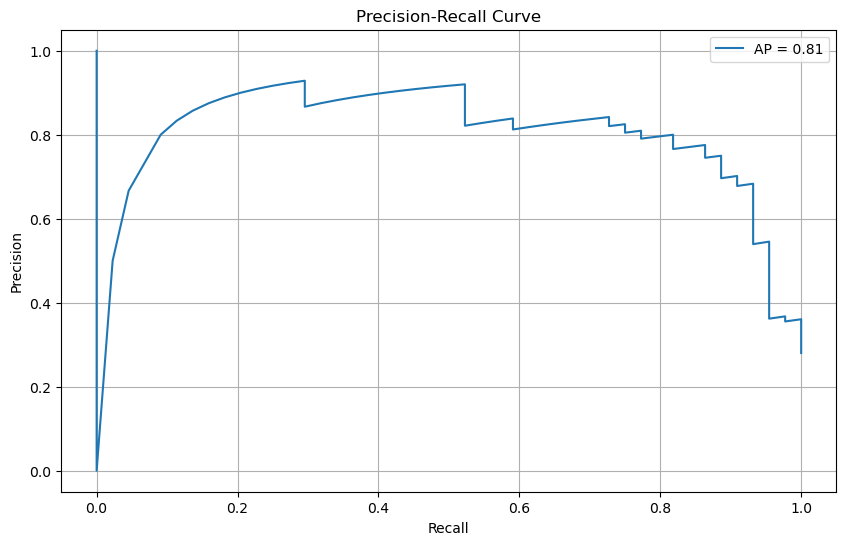

0.9078890681266785

In [136]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Plotting Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold that gives the highest precision
best_threshold_idx = np.argmax(precision[:-1])
best_threshold = thresholds[best_threshold_idx]

best_threshold



In [138]:
state_dict = model.state_dict()
torch.save(state_dict, "./saved_models/gnn-ckpt.pth")